In [1]:
import os
import sys
import numpy as np
import seaborn as sns
import pandas as pd

Below we define the *factor_analyzer* class with the methods:
* __\_\_init\_\___ (constructor)
* __get_params__ (defining a parameter dictionary)
* __fit__ (fitting routine excuting E and M steps)
* __e_step__ (compute first and second moment of the factors)
* __m_step__ (maximise likelihood of data)
* __stopping_criterion__ (evaluate convergence of algorithm)

SOURCE: *Ghahramani, Zoubin, and Geoffrey E. Hinton. The EM algorithm for mixtures of factor analyzers. Vol. 60. Technical Report CRG-TR-96-1, University of Toronto, 1996.*



In [2]:
class factor_analyzer():
    
    def __init__(self, data, k=2, random_state=0):
        """
        Factor analysis class constructor.
        Randomly initialize factor loading matrix and noise variances.
        
        Args:
        	data    {np.array} of shape (n,p), i.e. one sample per row.
        	k       {int} > 0 && < p, specifying how many latent factors are assumed.
        
        """
        from sklearn import preprocessing
        
        # Error handling
        try:
            assert data.shape[1] < data.shape[0] and k > 0
        except AssertionError:
            txt =  (
                "AssertionError. Please feed samples into rows and ensure there "
                "are more samples than dimensions. Make sure k > 0."
            )
            raise AssertionError(txt)
        
        # Data should be fed as n x p matrix with one sample per row and n > p.
        # Transpose for internal reasons, to simplify vectorization.
        self.data = np.transpose(preprocessing.scale(data))
        
        # Save hyperparameter into a dict
        self.params = self.get_params(k, random_state)
        
        
    def get_params(self, k, random_state):
        """
        Helper method to allocate dictionary with model parameters.
        """
        # Fix random seed
        np.random.seed(random_state)

        return {
            'k': k, 
            'p': self.data.shape[0],
            'n': self.data.shape[1],
            'F': np.random.normal(loc=0,scale=1, size=(self.data.shape[0], k)),
            'Psi': np.diag(1.0/np.cov(self.data)),
            'I': np.identity(k),
            'random_state': random_state
        }
    
    
    def fit(self):
        """
        Do EM steps.
        """
        maxsteps = 100
        steps = 0
        while not self.stopping_criterion() and steps < maxsteps:
            #print(self.params['F'])
            #print(self.params['Psi'])
            self.e_step()
            self.m_step()
            steps += 1
            
            
        self.params.update({
            'steps': steps,
            'noise_variance': np.diag(self.params.get('Psi',0))
        })
        return self.params
        
    def e_step(self):
        """
        Compute moments of factors given a sample.
        """ 
        # beta will be of shape p x n
        beta = np.matmul(
            np.transpose(self.params.get('F',0)),
            np.linalg.inv(
                self.params.get('Psi',0)+np.matmul(
                    self.params.get('F',0),
                    np.transpose(self.params.get('F',0))
                )
            )
        )
        assert beta.shape == (self.params.get('k',0), self.params.get('p',0))
        
        first_moment = np.matmul(beta, self.data)
        assert first_moment.shape == (self.params.get('k',0), self.params.get('n',0))

        second_moment = np.zeros((self.params.get('n',0),self.params.get('k',0),self.params.get('k',0))) 
        # Compute the second moment separately for every sample..
        for ind,sample in enumerate(self.data.T):
            second_moment[ind,::] = (
                self.params.get('I',0) - 
                np.matmul(beta, self.params.get('F',0)) + 
                np.linalg.multi_dot(
                    [beta, np.expand_dims(sample,1), np.transpose(np.expand_dims(sample,1)), np.transpose(beta)]
                )
            )                
        
        self.params.update({
            'f_m': first_moment,
            's_m': second_moment
        })
                        

    def m_step(self):
        """
        Maximize likelihood of factor loading matrix.
        """
        f_new = np.matmul(
            np.matmul(self.data, np.transpose(self.params.get('f_m',0))),
            np.linalg.inv(np.transpose(np.sum(self.params.get('s_m',0),0)))
        )
        assert f_new.shape == self.params.get('F',np.array([])).shape
        
        covariances = (
            np.matmul(self.data,np.transpose(self.data)) - 
            np.matmul(np.matmul(f_new, self.params.get('f_m',0)), np.transpose(self.data))
        )
        # set of diagonal to 0
        psi_new = (self.params.get('n',0)**-1)*np.diag(np.diag(covariances))
        assert psi_new.shape == (self.params.get('p',0),self.params.get('p',0))
        
        self.params.update({
            'F_old': self.params.get('F',0),
            'F': f_new,
            'Psi_old': self.params.get('Psi',0),
            'Psi': psi_new
        })
        
    def stopping_criterion(self, c=3):
        """
        Specify when to stop EM iterations herein. 
        Default is when parameter decimits are unchanged before c=3rd decimal digit
        """
        return (
            np.array_equal(
                abs(np.round(self.params.get('F_old',0),c) - np.round(self.params.get('F',0),c)),
                np.zeros(self.params.get('F',np.array([])).shape)
            ) and
            np.array_equal(
                abs(np.round(self.params.get('Psi_old',0),c) - np.round(self.params.get('Psi',0),c)),
                np.zeros(self.params.get('Psi',np.array([])).shape)
            )
        )
        


### To verify whether the implementation works, compare it to a sklearn built-in method.

In [3]:
def compare_factor_analyzer(data, iterations=20, num_factors=1):
    """
    Compare hand-crafted factor analysis class to sklearn method.
    Apply factor analysis for several random seeds and evaluate stability of estimated parameters.
    
    Args:
        - data {np.array} of shape num_samples x features.
        - iterations {int} > 0, how many iterations will be executed (default = 20).
        - num_factors {int} > 0, how many latent variables is searched for (default = 1).
        - plot {bool}, whether the results should be plotted.
    
    Returns:
        - df_F {pd.DataFrame} containing estimated factor loading matrix  for both methods (across runs).
        - df_Psi {pd.DataFrame} containing estimated variances for both methods (across runs).
    
    """
    
    df_F = pd.DataFrame()
    df_Psi = pd.DataFrame()

    for seed in range(iterations):
        
        if seed%5 == 0:
            print("Currently running iteration no. {}".format(seed))
        # Sklearn fit
        transformer = decomposition.FactorAnalysis(n_components=k, random_state=seed)
        transformer.fit(preprocessing.scale(data))

        df_F = pd.concat([
            df_F,
            pd.DataFrame({
                'F': abs(transformer.components_.flatten()),
                'type': "sklearn",
                "position": [x for x in zip(*np.where(~np.isnan(transformer.components_)))],
                'k': num_factors
            })
        ])
        df_Psi = pd.concat([
            df_Psi,
            pd.DataFrame({
                'Psi': transformer.noise_variance_,
                'type': "sklearn",
                "position": [x[0] for x in zip(*np.where(~np.isnan(transformer.noise_variance_)))],
                'k': num_factors
            })
        ])

        # My fit
        factor_model = factor_analyzer(data,k=k,random_state=seed)
        result = factor_model.fit()
        
        df_F = pd.concat([
            df_F,
            pd.DataFrame({
                'F': np.transpose(result.get('F',np.array([]))).flatten(),
                'type': "ghaharamani",
                "position": [
                    x for x in zip(*np.where(np.transpose(result.get('F',np.array([])))))
                ],
                'k': num_factors
            })
        ])
        df_Psi = pd.concat([
            df_Psi,
            pd.DataFrame({
                'Psi': result.get('noise_variance',0),
                'type': "ghaharamani",
                "position": [x[0] for x in zip(*np.where(result.get('noise_variance',0)))],
                'k': num_factors
            })
        ])
        
    return df_F, df_Psi

### Load some example datasets

In [4]:
from sklearn import datasets, decomposition, preprocessing
iris = datasets.load_iris()
boston = datasets.load_boston()

In [5]:
iterations = 10
k = 1

In [6]:
df_F, df_Psi = compare_factor_analyzer(iris.data, iterations, k)

Currently running iteration no. 0
Currently running iteration no. 5


/Users/jab/miniconda3/envs/rdkit3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


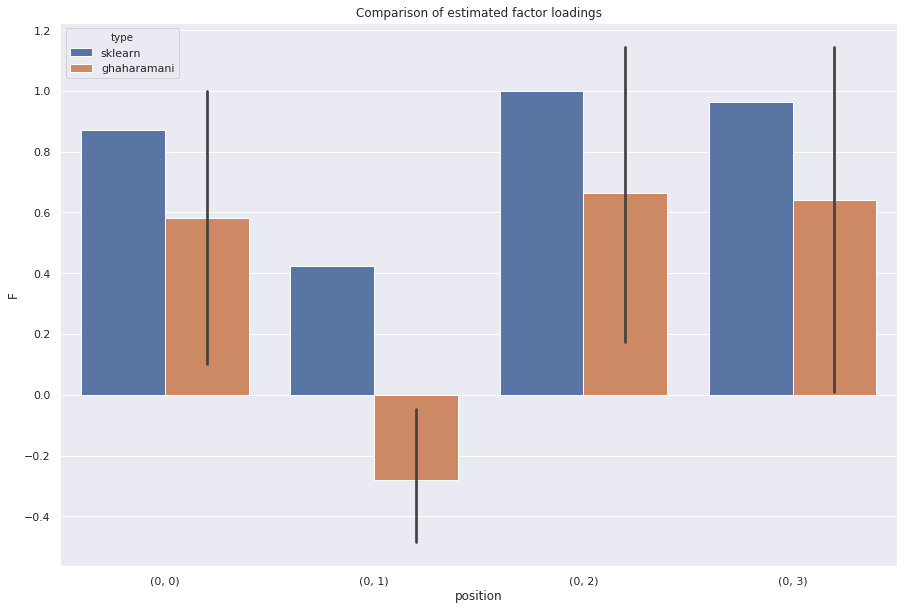

In [7]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="position", y="F", hue="type", data=df_F).set_title("Comparison of estimated factor loadings")


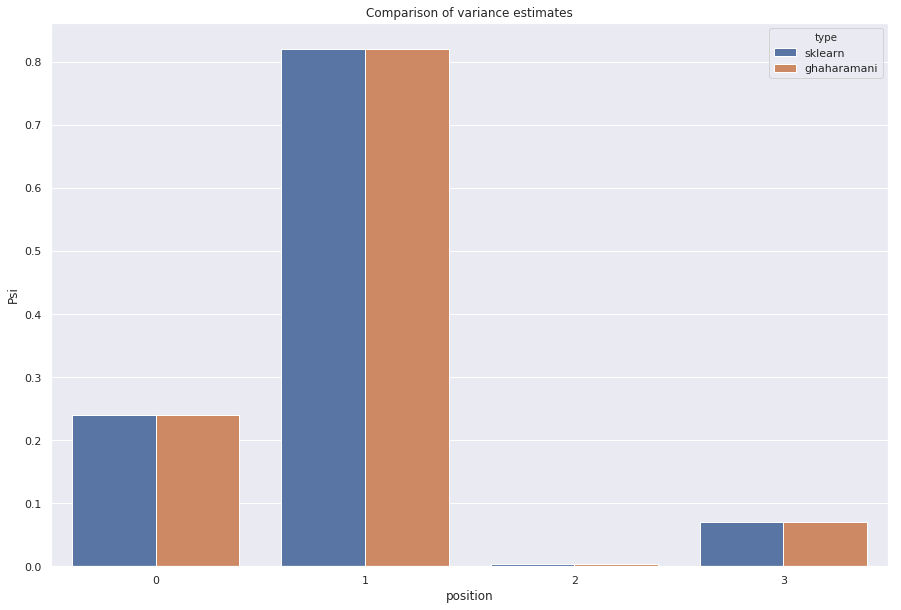

In [8]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="position", y="Psi", hue="type", data=df_Psi).set_title("Comparison of variance estimates")

#### Weird. Whilst the variances are estimated exactly like in the sklearn method, the factor loadings differ slightly, in particular the factor for the second feature has the wrong sign.
### I realised that the factor amplitudes were almost identical, only the sign changed in some random seeds

In [9]:
df_F[(df_F['type']=='ghaharamani') & (df_F['position']==(0,0))]

,F,type,position,k
0,0.789473,ghaharamani,"(0, 0)",1
0,0.806476,ghaharamani,"(0, 0)",1
0,0.806360,ghaharamani,"(0, 0)",1
0,0.807329,ghaharamani,"(0, 0)",1
0,0.829491,ghaharamani,"(0, 0)",1
0,-0.810394,ghaharamani,"(0, 0)",1
0,-0.775885,ghaharamani,"(0, 0)",1
0,0.770845,ghaharamani,"(0, 0)",1
0,1.769144,ghaharamani,"(0, 0)",1
0,0.809174,ghaharamani,"(0, 0)",1


#### Like the second-to-last line shows, the method can also get stuck in local minima and estimate other factor loadings.

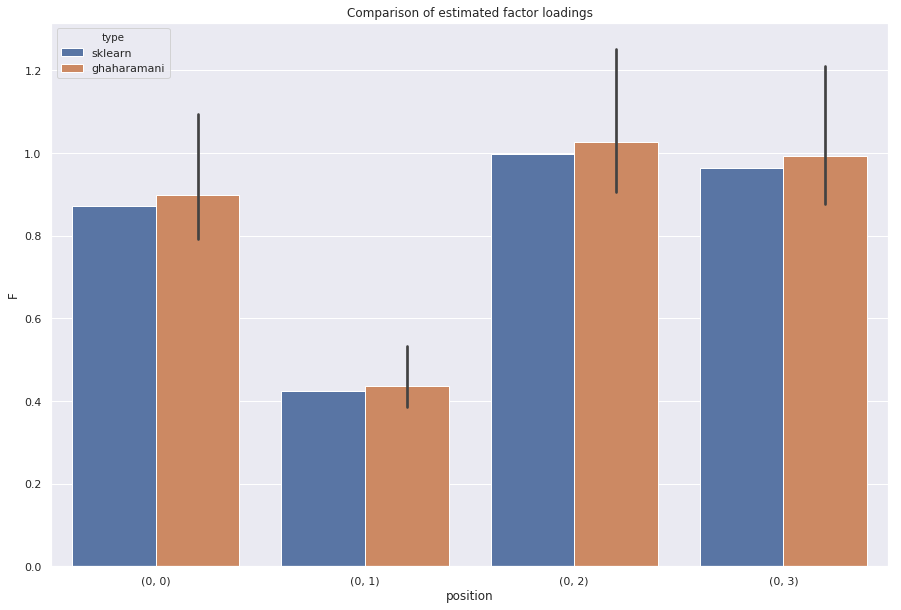

In [10]:
# Let's disregard the signs
df_F['F'] = abs(df_F['F'])

# plot factor loadings again
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="position", y="F", hue="type", data=df_F).set_title("Comparison of estimated factor loadings")

#### Now the estimated factor loadings are almost identical (apart from the run with the bad local optimum). I still find the thing with the sign very unexpected, since the factor loadings should reflect correlations which have a directional nature. To check if/what mistake I did, I searched for the original implementation by "Ghaharamani"

#### I downloaded the MATLAB code and ran it on the Iris dataset with the default settings of the enclosed function (*ffa.m*). To do this, I wrote 2 scripts:
* get_ghahramani_code.sh (downloads and unzips original code)
* original_iris.m (Matlab code that runs *ffa.m* on Iris data with different random seeds, for k=1 and k=2 latent factors).

#### Please see the respective files for details. Here I just read in the factor loading matrices produced by the original code.


In [11]:
from scipy.io import loadmat

x = loadmat('iris_result_1.mat')
loadings = x['loadings']
phis = x['phis']

df_F_all = pd.concat([
    df_F,
    pd.DataFrame({
        'F': np.transpose(loadings.flatten()),
        'type': "original_ghah.",
        "position":[
            x for k in range(loadings.shape[0]) 
            for x in zip(*np.where(np.transpose(np.expand_dims(loadings[0,:],1))))
        ],
        'k': 1
    })
])

df_Psi_all = pd.concat([
    df_Psi,
    pd.DataFrame({
        'Psi': np.transpose(phis.flatten()),
        'type': "original_ghah.",
        "position":[
            x[0] for k in range(phis.shape[0]) 
            for x in zip(*np.where(np.transpose(phis[0,:])))
        ],
        'k': 1
    })
])

### Now plot the parameter estimates of all 3 methods

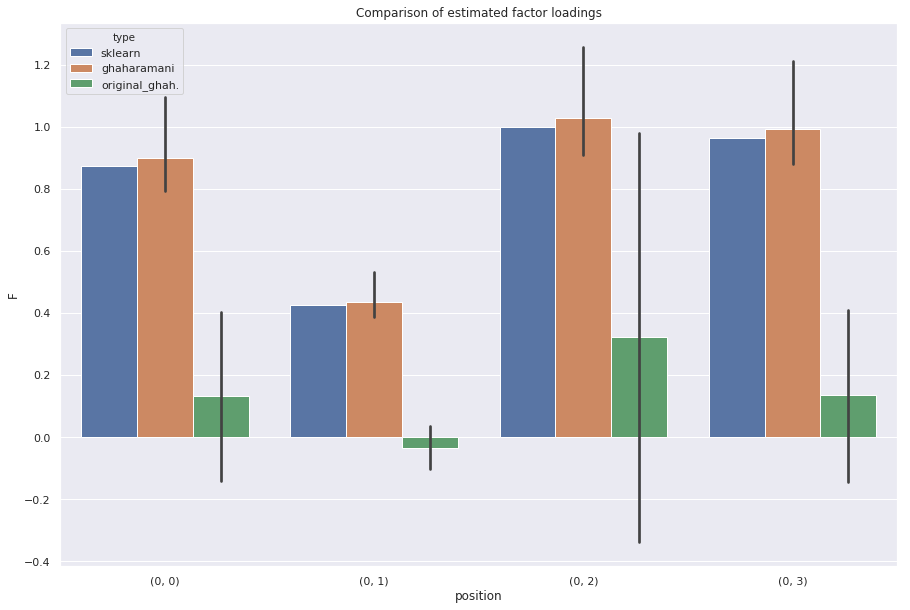

In [12]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="position", y="F", hue="type", data=df_F_all).set_title("Comparison of estimated factor loadings")


In [13]:
# The above figure shows that the parameters from the original code are also instable.
# Quick check of dataframe confirms this.
df_F_all[(df_F_all['type']=='original_ghah.') & (df_F_all['position']==(0,0))].iloc[:10]

,F,type,position,k
0,-0.671874,original_ghah.,"(0, 0)",1
4,0.667525,original_ghah.,"(0, 0)",1
8,0.667384,original_ghah.,"(0, 0)",1
12,0.669564,original_ghah.,"(0, 0)",1
16,0.669478,original_ghah.,"(0, 0)",1
20,0.673020,original_ghah.,"(0, 0)",1
24,-0.724887,original_ghah.,"(0, 0)",1
28,-0.669089,original_ghah.,"(0, 0)",1
32,0.677339,original_ghah.,"(0, 0)",1
36,-0.666747,original_ghah.,"(0, 0)",1


In [ ]:
# In addition, the variance estimates differ, too.
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="position", y="Psi", hue="type", data=df_Psi_all).set_title("Comparison of variance estimates")

In [ ]:
# Ignore sign, also for the original ghah. code
df_F_all['F'] = abs(df_F_all['F'])

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="position", y="F", hue="type", data=df_F_all).set_title("Comparison of estimated factor loadings")


### Let us run the model on another dataset (Boston houses)
#### For evaluation, ignore the sign of the factor loadings.

In [ ]:
# Boston dataset

df_F, df_Psi = compare_factor_analyzer(boston.data, iterations, k)

In [ ]:
# Plot factor loadings
df_F['F'] = abs(df_F['F'])

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="position", y="F", hue="type", data=df_F).set_title("Comparison of estimated factor loadings")

In [ ]:
# Plot variance estimates

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="position", y="Psi", hue="type", data=df_Psi).set_title("Comparison of variance estimates")

## This shows that the code gives stable results that are aligned with the sklearn FactorAnalysis function (apart from the sign of my parameter estimates that may alternate according to the initialization of EM; a problem that also occurs in the original code).